# Predicting Civil War Onset : What about other prediction model ? Which of them is the most relevant ?

## Abstract

At the end of their paper, the authors state that "the analyses [...] show that Random Forests offers superior predictve power compared to several forms of logistic regression". Then, when we read the paper, we asked ourselves : why the authors only used Logistic Regression and Random Forest methods ?

In this extension we will therefore try to compare Random Forest and Logistic Regression to some other methods as Support Vector Machine (SVM) and Least Square.
In our analysis, we will try to compare the accuracy of our models with the models of the paper by comparing the AUCs, we will also try to compare the robustness and the complexity of all the methods to highlight the more efficient one.

Finally, we will try to pinpoint the more important features when using our models. As a result, we will try to compare these features with the ones from Random Forests and then identify the most important ones in average.

## <a class="anchor"></a> Index
0. [Data pre-processing](#0.-Data-pre-processing)
    1. [Pre-Processing](#-Pre-Processing)
    2. [Missing Data ?](#-Missing-data-?)
    3. [Standardization](#-Standardization)
    4. [Categorical Data](#-Categorical-Data)
1. [Least Square Method](#-1.-Least-Square-Method)
    1. [Step 1 : Try the method with the 90 variables (sklearn)](#-Step-1-:-Try-the-method-with-the-90-variables-(sklearn))
      1. [Features and target selection](#-Features-and-target-selection)
      2. [Plot the ROC curves](#-Plot-the-ROC-curves)
      3. [Conclusion of Step 1](#-Conclusion-of-Step-1)
    2. [Step 2 : Find relevant variables](#-Step-2-:-Find-relevant-variables)
      1. [Selection of the most significant variables](#-Selection-of-the-most-significant-variables)
      2. [Conclusion of Step 2](#-Conclusion-of-Step-2)
    3. [Step 3 : Retry the linear regression method with significant variables (sklearn)](#-Step-3-:-Retry-the-linear-regression-method-with-significant-variables-(sklearn))
      1. [Features and target selection](#-Features-and-target-selection)
      2. [Plot the ROC curves](#-Plot-the-ROC-curves)
    4. [Conclusion and results analysis : Least Square Method](#-Conclusion-and-results-analysis-:-Least-Square-Method)
2. [SVM](#-2.-SVM)
3. [Neural Networks](#-3.-Neural-Networks)
4. [Bayes classifier](#-4.-Bayes-classifier)
5. [Analysis of results](#-5.-Analysis-of-results)
  1. [Replicate the Random Forests ROC curve](##-Replicate-the-Random-Forests-ROC-curve)
  2.[Extract Logistic Regression ROC Curves](##-Extract-Logistic-Regression-ROC-Curves)
  3. [Overall ROC plot](##-Overall-ROC-plot)
6. [Conclusion](#-6.-Conclusion)

In [1]:
# Importing libraries for data manipulation
import numpy as np
import pandas as pd

# Import of libraries for the visualization of results
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importation of libraries for model training.
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Import of libraries for the analysis of the results
from sklearn.metrics import mean_squared_error, auc, roc_curve
from sklearn.model_selection import cross_val_predict, cross_val_score,train_test_split

# <a class="anchor"></a> 0. Data pre-processing
[Back to index](#-Index)

## <a class="anchor"></a> Pre-Processing

In this project, we chose to compare different training models. One of the objectives is to compare the results obtained in this project with the models implemented in the paper. Thus, we have chosen to keep the data provided in the paper. Thus, in this project, we will use the ***Civil War Data (CWD)*** dataset.

This dataset is taken from the Civil War Data (CWD) and contains nearly **286 prediction variables**.
Each row corresponds to a country-year and contains the values of the 286 variables.
We can see that the values are quite different from one column to another.

Indeed, some columns have continuous values, other columns have discrete values (such as a number of years),
and finally, columns with binary values $\{0, 1\}$.
So we have a table composed of **7141 country-years** and **286 variables**.

In this study, we will keep only **90 of these variables**. These variables are the same variables used in the paper models. We also use these data since they are the most consistent with the results we are looking for.

In [6]:
# Loading data contained in the csv file.
data = pd.read_csv('SambnisImp.csv')

# Filtering of the initial table to keep only the 90 useful variables.
data_filtred = data[["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]]

# Display of the first lines of the filtered table
data_filtred.head()

,warstds,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,coldwar,decade1,decade2,decade3,decade4,dem,dem4,demch98,dlang,drel,durable,ef,ef2,ehet,elfo,elfo2,etdo4590,expgdp,exrec,fedpol3,fuelexp,gdpgrowth,geo1,geo2,geo34,geo57,geo69,geo8,illiteracy,incumb,...,mirps1,mirps2,mirps3,nat_war,ncontig,nmgdp,nmdp4_alt,numlang,nwstate,oil,p4mchg,parcomp,parreg,part,partfree,plural,plurrel,pol4,pol4m,pol4sq,polch98,polcomp,popdense,presi,pri,proxregc,ptime,reg,regd4_alt,relfrac,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
0,0,34.461765,8.510845,0,129472.9042,0,3.925812,0.005151,0.432955,1,1,0,0,0,0,0,3.995929,0,70.0,20.0,20.909713,0.750797,0.563696,90.0,66.0,2212.227998,1.0,33.592410,5.292369,0.132263,15.387903,0.022562,0.0,0.0,0.0,1.0,0.0,0.0,34.020639,0,...,0.16935,0.313143,0.373714,0,0.0,4508.131692,-0.475189,8.0,0.0,0,0.051008,2.733729,3.835219,2.43732,0,0.38,84.0,0.070117,0.068564,61.493014,0,5.059323,118.554791,0,87.931355,0.143299,12,0.581817,-0.413956,0.2718,43.770298,0.253,0.058441,0.46176,0.158275,0.052989,0.443259,72.881375,0,3.995912
1,0,34.346348,8.478997,0,129413.0225,0,10.000000,0.000000,0.045052,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2219.468491,1.0,33.561559,1.000000,0.000000,15.594645,0.022447,0.0,0.0,0.0,1.0,0.0,0.0,34.129908,0,...,0.00000,1.000000,0.000000,1,0.0,4491.340308,-5.000000,8.0,0.0,0,0.053837,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,117.756342,0,88.007471,1.000000,24,0.585308,-3.000000,0.2718,43.588363,0.253,0.000000,0.00000,0.158321,0.052663,1.000000,72.900089,0,1.000000
2,0,77.000000,8.481015,0,130431.0145,0,10.000000,0.000000,0.030034,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2219.825536,1.0,33.577128,1.000000,0.000000,15.601810,0.022372,0.0,0.0,0.0,1.0,0.0,0.0,34.183272,0,...,0.00000,1.000000,0.000000,1,0.0,4484.267686,-5.000000,8.0,0.0,0,0.000000,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,118.280656,0,87.972309,1.000000,36,1.000000,-3.000000,0.2718,43.538181,0.253,0.000000,0.00000,0.158425,0.052891,2.000000,72.962880,0,1.000000
3,0,78.000000,8.451628,0,126781.6866,0,10.000000,0.000000,0.022526,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2225.284783,1.0,33.625990,1.000000,0.000000,15.739340,0.022239,0.0,0.0,0.0,1.0,0.0,0.0,34.234445,0,...,0.00000,1.000000,0.000000,1,0.0,4474.082672,-4.500000,8.0,0.0,0,0.000000,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,118.325869,0,87.885682,1.000000,48,1.000000,-3.500000,0.2718,43.490005,0.253,0.000000,0.00000,0.159006,0.052902,2.000000,73.102449,0,1.000000
4,0,79.000000,8.500172,0,130979.2470,0,10.000000,0.000000,0.022526,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2216.878723,1.0,33.538608,1.000000,0.000000,15.525010,0.022462,0.0,0.0,0.0,1.0,0.0,0.0,34.164099,0,...,0.00000,1.000000,0.000000,1,0.0,4497.299503,-3.000000,8.0,0.0,0,0.000000,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,118.312296,0,87.947331,1.000000,60,1.000000,2.000000,0.2718,43.602238,0.253,0.000000,0.00000,0.158074,0.052706,2.000000,72.850389,0,1.000000


In [7]:
# Defining the corresponding output values and feature vectors for training the different models. The output vector is
# similar for each model while the feature vectors are different.
# The output binary variable signalling the onset of civil war. 1 corresponds to a recorded civil war while 0 corresponds to otherwise
y = data_filtred['warstds']

# All the variables can be used for training except the target variable which is warstds
X = data_filtred.drop(['warstds'], axis=1)

X.head()

,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,coldwar,decade1,decade2,decade3,decade4,dem,dem4,demch98,dlang,drel,durable,ef,ef2,ehet,elfo,elfo2,etdo4590,expgdp,exrec,fedpol3,fuelexp,gdpgrowth,geo1,geo2,geo34,geo57,geo69,geo8,illiteracy,incumb,infant,...,mirps1,mirps2,mirps3,nat_war,ncontig,nmgdp,nmdp4_alt,numlang,nwstate,oil,p4mchg,parcomp,parreg,part,partfree,plural,plurrel,pol4,pol4m,pol4sq,polch98,polcomp,popdense,presi,pri,proxregc,ptime,reg,regd4_alt,relfrac,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
0,34.461765,8.510845,0,129472.9042,0,3.925812,0.005151,0.432955,1,1,0,0,0,0,0,3.995929,0,70.0,20.0,20.909713,0.750797,0.563696,90.0,66.0,2212.227998,1.0,33.592410,5.292369,0.132263,15.387903,0.022562,0.0,0.0,0.0,1.0,0.0,0.0,34.020639,0,68.655361,...,0.16935,0.313143,0.373714,0,0.0,4508.131692,-0.475189,8.0,0.0,0,0.051008,2.733729,3.835219,2.43732,0,0.38,84.0,0.070117,0.068564,61.493014,0,5.059323,118.554791,0,87.931355,0.143299,12,0.581817,-0.413956,0.2718,43.770298,0.253,0.058441,0.46176,0.158275,0.052989,0.443259,72.881375,0,3.995912
1,34.346348,8.478997,0,129413.0225,0,10.000000,0.000000,0.045052,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2219.468491,1.0,33.561559,1.000000,0.000000,15.594645,0.022447,0.0,0.0,0.0,1.0,0.0,0.0,34.129908,0,68.918002,...,0.00000,1.000000,0.000000,1,0.0,4491.340308,-5.000000,8.0,0.0,0,0.053837,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,117.756342,0,88.007471,1.000000,24,0.585308,-3.000000,0.2718,43.588363,0.253,0.000000,0.00000,0.158321,0.052663,1.000000,72.900089,0,1.000000
2,77.000000,8.481015,0,130431.0145,0,10.000000,0.000000,0.030034,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2219.825536,1.0,33.577128,1.000000,0.000000,15.601810,0.022372,0.0,0.0,0.0,1.0,0.0,0.0,34.183272,0,69.017545,...,0.00000,1.000000,0.000000,1,0.0,4484.267686,-5.000000,8.0,0.0,0,0.000000,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,118.280656,0,87.972309,1.000000,36,1.000000,-3.000000,0.2718,43.538181,0.253,0.000000,0.00000,0.158425,0.052891,2.000000,72.962880,0,1.000000
3,78.000000,8.451628,0,126781.6866,0,10.000000,0.000000,0.022526,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2225.284783,1.0,33.625990,1.000000,0.000000,15.739340,0.022239,0.0,0.0,0.0,1.0,0.0,0.0,34.234445,0,69.126788,...,0.00000,1.000000,0.000000,1,0.0,4474.082672,-4.500000,8.0,0.0,0,0.000000,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,118.325869,0,87.885682,1.000000,48,1.000000,-3.500000,0.2718,43.490005,0.253,0.000000,0.00000,0.159006,0.052902,2.000000,73.102449,0,1.000000
4,79.000000,8.500172,0,130979.2470,0,10.000000,0.000000,0.022526,1,1,0,0,0,0,0,0.000000,0,70.0,20.0,0.000000,0.750797,0.563696,90.0,66.0,2216.878723,1.0,33.538608,1.000000,0.000000,15.525010,0.022462,0.0,0.0,0.0,1.0,0.0,0.0,34.164099,0,68.960291,...,0.00000,1.000000,0.000000,1,0.0,4497.299503,-3.000000,8.0,0.0,0,0.000000,1.000000,4.000000,1.00000,0,0.38,84.0,-10.000000,-10.000000,100.000000,0,1.000000,118.312296,0,87.947331,1.000000,60,1.000000,2.000000,0.2718,43.602238,0.253,0.000000,0.00000,0.158074,0.052706,2.000000,72.850389,0,1.000000


## <a class="anchor"></a> Missing data ?
At first glance, the data seems to be complete. However, if there are missing data,
we will have to process them in order to be able to correctly carry out our predictions.

As shown below, there are no missing values.

In [8]:
number_missing_data = len(data_filtred[data_filtred.isna().any(axis=1)])
print(f"There is {number_missing_data} missing data")

There is 0 missing data


## <a class="anchor"></a> Standardization
With CWD, there are large differences in values.

Some models will need standardized values because standardization will allow to **accelerate convergence** (which does not have a big impact unless the dataset is very large) and will allow a **better interpretation of the coefficients** and their importance.

We will use standardization performing the following calculation:

$$ X' = \frac{\textbf{X} - \mu}{\sigma}$$

$\mu$ is the **mean of the feature** values and
$\sigma$ is the **standard deviation** of the feature values.

***Note***: No standardization for binary variables that have $\{0, 1\}$ as a set.

In [9]:
"""
For each variable (col in df.columns) we will standardize all the values.
To do this we remove the average from each value of the column: df[col].mean()
Then we divide by the standard deviation: df[col].std()

Each column will be standardized, except for binary variables.
(which have as a set of values: {0, 1}).
"""
def standardize(df):
    # We select a column
    for col in df.columns:
        # We check if it is a binary variable
        if df[col].nunique() > 10:
            # If it is not a binary variable,
            # then standardization is achieved
            df[col] = (df[col] - df[col].mean())/df[col].std()

    # Returns the table with all
    # standardized values, column by column
    return df

## <a class="anchor"></a> Categorical Data
Thus, as explained above, we are not going to standardize categorical data. The code below allows to visualize the categorical data and their set of values. Globally, these variables are binary variables, such as **dem** which is equal to 1 if the country is a democracy and 0 otherwise.

In [10]:
# Find categorical data
def is_categ(df):
    for col in df.columns:
        # if the cardinal of the set of values of a vector is less than 10,
        # it is considered a categorical variable.
        if len(set(df[col].values)) < 10:
            print(col, '     \t:\t', set(df[col].values))

is_categ(data_filtred)

warstds      	:	 {0, 1}
anoc      	:	 {0, 1}
centpol3      	:	 {0, 1}
coldwar      	:	 {0, 1}
decade1      	:	 {0, 1}
decade2      	:	 {0, 1}
decade3      	:	 {0, 1}
decade4      	:	 {0, 1}
dem      	:	 {0, 1}
incumb      	:	 {0, 1}
inst      	:	 {0, 1, 2, 3}
major      	:	 {0, 1}
nat_war      	:	 {0, 1}
oil      	:	 {0, 1}
partfree      	:	 {0, 1}
presi      	:	 {0, 1}
warhist      	:	 {0, 1}


# <a class="anchor"></a> 1. Least Square Method

In the case of a dataset composed of **continuous** and **categorical variables**, it seems obvious that the least square method is not the most suitable method. Thus, it seemed interesting to analyze the behavior of this method in front of this non-linear dataset. Indeed, it is legitimate to wonder **to what extent the least square method is wrong** : *Can it, in spite of everything, give coherent results ?*

In order to carry out this first study of the **least square model**. We are going to start by naively carrying out a regression with the **90 initial variables**. Then, we will be able to evaluate the most **influential data** concerning this model. Indeed, the **p-value** of the variables will allow us to establish the list of variables that allow the best prediction. Finally, we will perform a new training of the model with the **significant variables**.

To summarize, here are the three steps of this first part:
- Step 1 : Try the method with the 90 variables (sklearn)
- Step 2 : Try to find significant variables (statmodels)
- Step 3 : Retry the linear regression method with significant variables (sklearn)

## <a class="anchor"></a> Step 1 : Try the method with the 90 variables (sklearn)
In this first step, the 90 previously selected variables are used and then the model is trained with the LinearRegression function.

### <a class="anchor"></a> Features and target selection

In [11]:
# target vector y for regression
y = data['warstds']

# features
X = data_filtred
X = X.drop('warstds',axis=1)

***Note***: *warstds* corresponds to the onset of a civil war. If the value is 1, then this line is a civil war outbreak, otherwise the value is 0. This vector is the target vector, so it makes sense to remove this vector from the features.

In [12]:
# assignment of the model
model = linear_model.LinearRegression()

# assignment of the title of the graph
graph_title = "Least square"

# Predict the probabilities with a cross validation
y_pred = cross_val_predict(model, X,y, cv=10)

# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y, y_pred[:])

# Compute the area under the ROC curve
auc_score = auc(fpr, tpr)

### <a class="anchor"></a> Plot the ROC curves

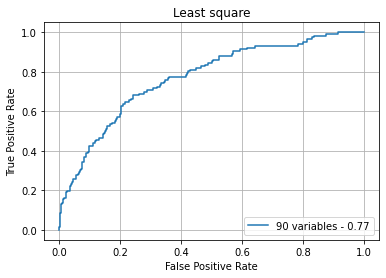

In [13]:
# Stores the ROC curve plot for each model.
plt.plot(fpr, tpr, label="90 variables" + " - {:.2f}".format(auc_score))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Drawing ROC curves with the legend
plt.legend(loc='lower right')
# Adding the title according to the selected regression type
plt.title(graph_title)
plt.grid()
plt.show()

In [14]:
y_pred

array([-0.0147652 ,  0.00527868, -0.00597836, ..., -0.01307763,
       -0.00294437,  0.01616962])

### <a class="anchor"></a> Conclusion of Step 1
In this first example, we see that the AUC score is 80%, a surprisingly high score. Indeed, a linear model is supposed to have a lower score on such a dataset.

In a binary classification problem, what we are interested in is the probability of an outcome occurring. Probability is ranged between 0 and 1. But, with **y_pred**, we can conclud that in linear regression, we are predicting an absolute number, which can range outside 0 and 1.

Linear regression might work, but **logistic regression** is more suitable for classification task as we can see in the paper.

## <a class="anchor"></a> Step 2 : Find relevant variables
In this second step, the statmodel library is used in order to have a good visualization of the importance of the data. Indeed, statmodel allows us to obtain the p-values of each variable, as well as the coefficients of these variables. We can then select the variables that best train the model.

In [15]:
# Declares the model
import statsmodels.formula.api as smf

mod = smf.ols(formula='warstds ~ + ager + agexp + C(anoc) + army85 + autch98 + auto4 + \
                              autonomy + avgnabo + C(centpol3) + C(coldwar) + C(decade1) + C(decade2) + \
                              C(decade3) + C(decade4) + C(dem) + dem4 + demch98 + dlang + drel + durable + \
                              ef + ef2 + ehet + elfo + elfo2 + etdo4590 + expgdp + exrec + fedpol3 + \
                              fuelexp + gdpgrowth + geo1 + geo2 + geo34 + geo57 + geo69 + geo8 + \
                              illiteracy + C(incumb) + infant + inst + inst3 + life + lmtnest + \
                              ln_gdpen + lpopns + C(major) + manuexp + milper + mirps0 + mirps1 + \
                              mirps2 + mirps3 + C(nat_war) + ncontig + nmgdp + nmdp4_alt + numlang + \
                              nwstate + C(oil) + p4mchg + parcomp + parreg + part + C(partfree) + plural + \
                              plurrel + pol4 + pol4m + pol4sq + polch98 + polcomp + popdense + pri + \
                              proxregc + ptime + reg + regd4_alt + relfrac + seceduc + second + C(presi) + \
                              semipol3 + sip2 + sxpnew + sxpsq + tnatwar + trade + C(warhist) + xconst', data=data_filtred)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:                warstds   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     4.404
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.81e-37
Time:                        13:21:05   Log-Likelihood:                 4824.1
No. Observations:                7140   AIC:                            -9472.
Df Residuals:                    7052   BIC:                            -8867.
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1171      0.074  

In [16]:
# feature names
variables = res.params.index

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

### <a class="anchor"></a> Selection of the most significant variables

In [17]:
# Filter with P value
new_data = []

for i in range(len(l4)):
    # select the variable if its p-value is lower than 5%
    if l4[i] < 0.05:
        new_data.append(l2[i])
new_data

['gdpgrowth',
 'sxpnew',
 'second',
 'proxregc',
 'C(presi)[T.1]',
 'tnatwar',
 'parreg',
 'manuexp',
 'popdense',
 'agexp',
 'auto4',
 'C(decade4)[T.1]',
 'C(nat_war)[T.1]',
 'inst3',
 'mirps0',
 'nwstate']

### <a class="anchor"></a> Conclusion of Step 2
Thus, it is observed that of the **90 initial variables**, only **16 are significant**. In fact, based on the **P-values** obtained with the model created with the statmodel library, only 16 variables with a p-value lower than 5% are included.   Moreover, the realization of this model and the display of the result table, gives us access to other interesting values such as **coefficients**. These coefficients allow us to understand to what extent and with what weight these variables have an influence on the model.

Let's take as an example the variable **'gdpgrowth'** which represents the **growth in GDP**. The coefficient given by statmodel is **-0.1146**, which implies that the probability of having a war outbreak is inversely proportional to the increase in GDP with a factor of 0.1146.
This observation is consistent, in particular, with the results obtained in the paper: "The best predictor of civil war onset is national poverty as measured by both the growth rate of national gross domestic product (GDP) and GDP per capita".

Now, we have one model trained by linear regression. We can discuss this model performance by using the coefficient of determination (R² score). As we know, R² is a measure of how closely the tested data points are to the fitted regression line. In this case, we have **R² = 0.052**, which is far too low a value to assert that the linear regression model is efficient.

## <a class="anchor"></a> Step 3 : Retry the linear regression method with significant variables (sklearn)
In this last part, we will reexamine the model but with the **16 most significant variables**. Thus, the objective is to observe if the results given by this new model are more accurate.

### <a class="anchor"></a> Features and target selection

In [18]:
# features
new_data = ['gdpgrowth', 'sxpnew', 'second', 'proxregc', 'presi',
             'tnatwar', 'parreg', 'manuexp', 'popdense', 'agexp', 'auto4',
             'decade4', 'nat_war', 'inst3', 'mirps0', 'nwstate']

X_newdata = data[new_data]

# target vector y for regression
y = data['warstds']

In [19]:
# assignment of the model
model = linear_model.LinearRegression()

# Predict the probabilities with a cross validation
y_pred = cross_val_predict(model, X_newdata, y, cv=10)

# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y, y_pred[:])

# Compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr)

### <a class="anchor"></a> Plot the ROC curves

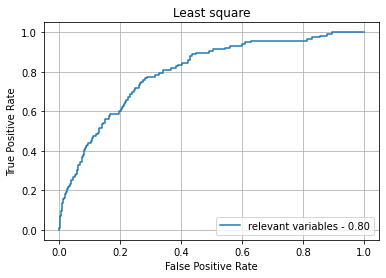

In [20]:
# Stores the ROC curve plot for each model.
plt.plot(fpr, tpr, label="relevant variables" + " - {:.2f}".format(auc_score))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Drawing ROC curves with the legend
plt.legend(loc='lower right')
# Adding the title according to the selected regression type
plt.title(graph_title)
plt.grid()
plt.show()

## <a class="anchor"></a> Conclusion and results analysis : Least Square Method

Applying linear regression for classification is not an absurd idea, but we observe that the results are very bad compared to the results obtained with logistic regression or other classification methods, which are preferred over linear regression.

Indeed, even if the **AUC scores are high**, it does not allow to assert that the least square method is efficient, whatever the features selected. For example, the low **R² proves that the model is not so efficient**.

In this case, there are **two main problems**: the predicted value is continuous, not probabilistic and the model is sensitive to imbalance data.

Linear regression is suitable for predicting output that is continuous value. It would therefore be more interesting to analyze **other classification methods** that will undoubtedly be more efficient than the least square method.


There are a total of 74 continuous features out of 91 total fields and rest 17 are categorical variables

In [21]:
# Standardising all the continuous features for better scaling of variables
X_std = X.copy()
X_std = standardize(X_std)
X_std

,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,coldwar,decade1,decade2,decade3,decade4,dem,dem4,demch98,dlang,drel,durable,ef,ef2,ehet,elfo,elfo2,etdo4590,expgdp,exrec,fedpol3,fuelexp,gdpgrowth,geo1,geo2,geo34,geo57,geo69,geo8,illiteracy,incumb,infant,...,mirps1,mirps2,mirps3,nat_war,ncontig,nmgdp,nmdp4_alt,numlang,nwstate,oil,p4mchg,parcomp,parreg,part,partfree,plural,plurrel,pol4,pol4m,pol4sq,polch98,polcomp,popdense,presi,pri,proxregc,ptime,reg,regd4_alt,relfrac,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
0,0.011565,-0.075864,0,-0.097323,0.016433,-0.005731,-0.018215,-0.053497,1,1,0,0,0,0,0,0.036617,-0.007954,2.034073,0.674190,0.044620,1.139412,1.154173,1.399676,1.024358,-0.103627,1.217898,0.129720,-0.000112,0.023650,0.008895,0.048956,-0.447912,-0.313333,-0.404907,2.188681,-0.494786,-0.572030,-0.091235,0,-0.102908,...,-0.053534,0.023334,0.039453,0,-0.482135,0.083025,0.066878,0.163446,-0.176643,0,-0.005434,0.039158,0.085558,0.026600,0,-1.181714,0.559973,0.022946,0.020438,0.083956,-0.012329,0.032660,0.007209,0,0.065018,-0.055465,-1.434843,-0.037920,0.065695,-0.438745,0.076855,0.919162,-0.007550,0.026881,0.094095,0.052437,-0.139284,0.107157,0,0.033310
1,0.008046,-0.079254,0,-0.097473,0.016433,1.775804,-0.082597,-1.315951,1,1,0,0,0,0,0,-0.957885,-0.007954,2.034073,0.674190,-0.890614,1.139412,1.154173,1.399676,1.024358,-0.100341,1.217898,0.127981,-1.837660,-0.427102,0.019952,0.047054,-0.447912,-0.313333,-0.404907,2.188681,-0.494786,-0.572030,-0.085188,0,-0.097076,...,-0.514203,1.615061,-0.791651,1,-0.482135,0.075998,-0.615201,0.163446,-0.176643,0,-0.003915,-1.107343,0.260116,-0.976421,0,-1.181714,0.559973,-1.363433,-1.365951,1.375977,-0.012329,-1.104402,0.004378,0,0.068186,2.469927,-1.366587,-0.030636,-0.334618,-0.438745,0.069821,0.919162,-0.287012,-1.219573,0.094547,0.049137,0.509491,0.107596,0,-1.298861
2,1.308743,-0.079039,0,-0.094927,0.016433,1.775804,-0.082597,-1.364826,1,1,0,0,0,0,0,-0.957885,-0.007954,2.034073,0.674190,-0.890614,1.139412,1.154173,1.399676,1.024358,-0.100179,1.217898,0.128859,-1.837660,-0.427102,0.020336,0.045803,-0.447912,-0.313333,-0.404907,2.188681,-0.494786,-0.572030,-0.082236,0,-0.094866,...,-0.514203,1.615061,-0.791651,1,-0.482135,0.073038,-0.615201,0.163446,-0.176643,0,-0.032830,-1.107343,0.260116,-0.976421,0,-1.181714,0.559973,-1.363433,-1.365951,1.375977,-0.012329,-1.104402,0.006237,0,0.066722,2.469927,-1.298331,0.834654,-0.334618,-0.438745,0.067881,0.919162,-0.287012,-1.219573,0.095567,0.051447,1.674799,0.109070,0,-1.298861
3,1.339237,-0.082167,0,-0.104053,0.016433,1.775804,-0.082597,-1.389263,1,1,0,0,0,0,0,-0.957885,-0.007954,2.034073,0.674190,-0.890614,1.139412,1.154173,1.399676,1.024358,-0.097701,1.217898,0.131611,-1.837660,-0.427102,0.027691,0.043607,-0.447912,-0.313333,-0.404907,2.188681,-0.494786,-0.572030,-0.079404,0,-0.092440,...,-0.514203,1.615061,-0.791651,1,-0.482135,0.068776,-0.539830,0.163446,-0.176643,0,-0.032830,-1.107343,0.260116,-0.976421,0,-1.181714,0.559973,-1.363433,-1.365951,1.375977,-0.012329,-1.104402,0.006397,0,0.063117,2.469927,-1.230075,0.834654,-0.412016,-0.438745,0.066018,0.919162,-0.287012,-1.219573,0.101303,0.051559,1.674799,0.112345,0,-1.298861
4,1.369731,-0.077000,0,-0.093556,0.016433,1.775804,-0.082597,-1.389263,1,1,0,0,0,0,0,-0.957885,-0.007954,2.034073,0.674190,-0.890614,1.139412,1.154173,1.399676,1.024358,-0.101516,1.217898,0.126688,-1.837660,-0.427102,0.016228,0.047307,-0.447912,-0.313333,-0.404907,2.188681,-0.494786,-0.572030,-0.083296,0,-0.096137,...,-0.514203,1.615061,-0.791651,1,-0.482135,0.078492,-0.313717,0.163446,-0.176643,0,-0.032830,-1.107343,0.260116,-0.976421,0,-1.181714,0.559973,-1.363433,-1.365951,1.375977,-0.012329,-1.104402,0.006349,0,0.065683,2.469927,-1.161819,0.834654,0.439369,-0.438745,0.070357,0.919162,-0.287012,-1.219573,0.092107,0.049569,1.674799,0.106430,0,-1.298861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

# <a class="anchor"></a> 2. SVM
[Back to index](#-Index)

Now, we will try to fit SVM to the dataset for predicting the onset of civil war. Instead of binary prediction, we will fit a SVM which outputs the 
probability of belonging to a class so that we can plot a ROC curve by varying the threshold probability and obtain the respective AUC. 
We use a 'RBF' kernel instead of a linear kernel for SVM to get a better fit and perform the regular fitting pipeline for getting the respective values of AUC.

In [22]:
# fitting a svm model with default parameters
model_Svm = svm.SVC(probability = True, gamma = 'scale')
# Training the model by cross validation. Employing cross validation is preferable to just training on the whole
# dataset and predicting on the same dataset as the latter approach entails overfitting. 

# Predict the probabilities with a cross validation
y_pred_svm = cross_val_predict(model_Svm, X_std, y, cv=5,method='predict_proba')
# Compute the False Positive Rate and True Positive Rate
fpr_svm, tpr_svm, _ = roc_curve(y, y_pred_svm[:,1])
# Compute the area under the fpr-tpr curve
auc_score_svm = auc(fpr_svm, tpr_svm)

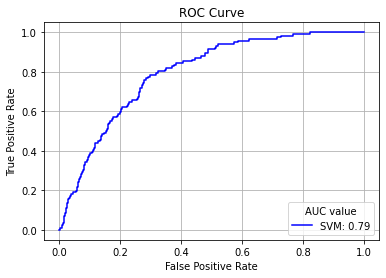

In [23]:
plt.plot(fpr_svm, tpr_svm, 'b', label ="SVM: " + str(round(auc_score_svm,2)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve");
plt.legend(loc="lower right",title="AUC value")
plt.grid()
plt.show()

The AUC value we obtain is better to the ones we obtained from logistic regression and are slightly lower than those obtained by Random forests. The disadvantage of SVM is that we can not ascertain the feature importance when we employ RBF kernel. In fact, SVM prediction using RBF kernel looks like :

<div align="center">$sign(\sum_{i=1}^N \alpha_i y_i e^{-\gamma || x_i - x ||^2}+\rho)$</div>

The influence of each training point is determined by its overall importance. Using RBF kernel, we can say that SVM behaves like soft nearest neighbours since closer points have an exponentially larger effect on the prediction. While it can be easily done for Random forests by observing the gini score of the features, we cannot speak about feature importance when it comes to SVM using RBF kernel. Then, even if the AUC score is quite good, some properties of SVM limits its use.


# <a class="anchor"></a> 3. Neural Networks
[Back to index](#-Index)

We will try to use a neural network to classify the dataset according to the variables. As neural networks have been shown to have a higher accuracy than the traditional methods, it is expected that this method should lead to a better AUC. We are going to employ multi-layer perceptron classifier to predict the onset of civil war.

In [24]:
mlp = MLPClassifier()


In [25]:
# Defining parameter space for best selection of hyperparameters
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.01, 0.1],
    'learning_rate': ['constant','adaptive'],
}

In [26]:
from sklearn.model_selection import GridSearchCV
# Performing a grid search on all the hyperparameters
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_std, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.01, 0

In [27]:
# Best parameter set
print('Best parameters found:\n', clf.best_params_)

Best parameters found:
 {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}


In [ ]:
#Defining a new MLP classifier with learned parameters
clf = MLPClassifier(hidden_layer_sizes=(50,50,50), max_iter=500, alpha=0.01,
                     solver='sgd')
# Training the model by cross validation. Employing cross validation is preferable to just training on the whole
# dataset and predicting on the same dataset as the latter approach entails overfitting. 

# Predict the probabilities with a cross validation
y_pred_nn = cross_val_predict(mlp, X_std, y, cv=5, method="predict_proba")
# Compute the False Positive Rate and True Positive Rate
fpr_nn, tpr_nn, _ = roc_curve(y, y_pred_nn[:, 1])
# Compute the area under the fpr-tpr curve
auc_score_nn = auc(fpr_nn, tpr_nn)

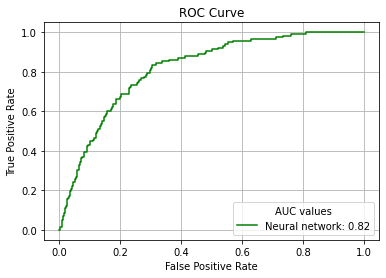

In [31]:
plt.plot(fpr_nn, tpr_nn, 'g', label ="Neural network: " + str(round(auc_score_nn,2)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve");
plt.legend(loc="lower right",title="AUC values")
plt.grid()
plt.show()

The AUC values, as expected are on the higher side but still do not have any significant advantage over the ones that we observe from Random forests. The AUC values can be increase by performing hyperparameter optimisation on a larger set

# <a class="anchor"></a> 4. Bayes classifier
[Back to index](#-Index)

We also try to implement the simplest method of classification, bayes classifier, to benchmark the accuracy of other methods 

In [32]:
model_naive = GaussianNB()

# Training the model by Fearon and laitin by cross validation. Employing cross validation is preferable to just training on the whole
# dataset and predicting on the same dataset as the latter approach entails overfitting. 

# Predict the probabilities with a cross validation
y_pred_bayes = cross_val_predict(model_naive, X_std, y, cv=5, method="predict_proba")
# Compute the False Positive Rate and True Positive Rate
fpr_bayes, tpr_bayes, _ = roc_curve(y, y_pred_bayes[:, 1])
# Compute the area under the fpr-tpr curve
auc_score_bayes = auc(fpr_bayes, tpr_bayes)

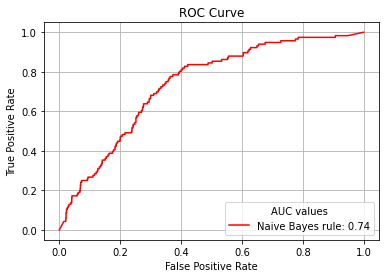

In [33]:
plt.plot(fpr_bayes, tpr_bayes, 'r', label ="Naive Bayes rule: " + str(round(auc_score_bayes,2)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve");
plt.legend(loc="lower right",title="AUC values")
plt.grid()
plt.show()

Even by using this simple method, we could get a AUC atleast of 0.73 and it makes sense to consider only those methods which have a higher AUC than this value. By this method, we could get an average AUC score.

# <a class="anchor"></a> 5. Analysis of results
[Back to index](#-Index)

Through this whole study, we used Receiver Operating Characteristic Curves (as known as ROC Curves) to visualize the predictive performance of the different classifiers. These curves are quite useful since it measures true and false positive for a classifier and it can be wrapped up using a single value which is the Area Under the Curve (AUC). The higher the AUC, the better the classifier's accuracy. 

In order to get a clear idea about what is the best model in predicting civil war onsets and to compare quickly all the previous methods, we plotted all the previous ROC curves in a single graph. We also added the replication of the ROC curves of the paper. More specificly, we added ROC curve for Random Forests and the "best" ROC curve for uncorrected and penalized logistic regression (it corresponds respectively to Collier & Hoeffler model and to Hegre & Sambanis)

## Replicate the Random Forests ROC curve

For this we used `RandomForestClassifier` from sklearn using the exact same parameters than the authors (see Replication Report). Then, in order to predict civil war onsets, we used 5-fold cross validation. 

In [34]:
# Creating a Random Forests model with default parameters
mod = RandomForestClassifier(n_estimators = 1000, oob_score=True, criterion='gini')

# Training the model by cross validation. Employing cross validation is preferable to just training on the whole
# dataset and predicting on the same dataset as the latter approach entails overfitting. 

# Predict the probabilities with a cross validation
y_pred_rf = cross_val_predict(mod, X_std, y, cv=5, method="predict_proba")
# Compute the False Positive Rate and True Positive Rate
fpr_rf, tpr_rf, _ = roc_curve(y, y_pred_rf[:, 1])
# Compute the area under the fpr-tpr curve
auc_score_rf = auc(fpr_rf, tpr_rf)

## Extract Logistic Regression ROC Curves

Since, we have to replicate the Logistic Regression ROC Curves in the replication milestone, we stored the data in .csv to use it in this project. In order to not overload our final figure, we will only use the "best" uncorrected and penalized models from the paper : the uncorrected Collier & Hoeffler and the penalized Hegre & Sambanis.

In [35]:
# The idea is to compare the previous model with the best results of the uncorrected and penalized logistic regression of the paper
# As a result we will use the uncorrected Collier and Hoeffler model and the penalized Hegre and Sambanis model.

# Extracting values from the replication report
un_col = pd.read_csv('uncorrected_collier.csv')
pen_heg = pd.read_csv('corrected_hegre.csv')

# Extract the fpr and tpr
fpr_un_col = np.array(un_col.fpr2)
tpr_un_col = np.array(un_col.tpr2)
# Compute the area under the fpr-tpr curve
auc_score_col = auc(fpr_un_col, tpr_un_col)

# Extract the fpr and tpr
fpr_pen_heg = np.array(pen_heg.fpr6)
tpr_pen_heg = np.array(pen_heg.tpr6)
# Compute the area under the fpr-tpr curve
auc_score_pen_heg = auc(fpr_pen_heg, tpr_pen_heg)

## Overall ROC plot

We didn't plot Least Square results since, as said before, it is not really relevant to compare this model, which cannot deal with categorical data, with the other models.

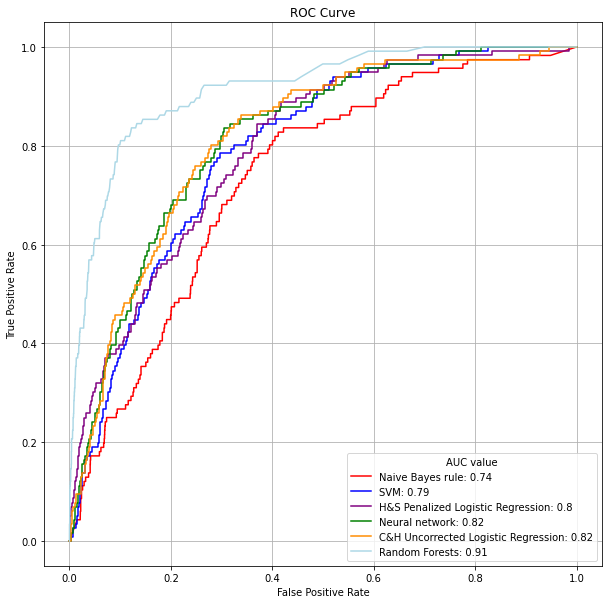

In [37]:
# Plot the overall figure
plt.figure(figsize=(10,10))
plt.plot(fpr_bayes, tpr_bayes, 'r', label ="Naive Bayes rule: " + str(round(auc_score_bayes,2)))
plt.plot(fpr_svm, tpr_svm, 'b', label ="SVM: " + str(round(auc_score_svm,2)))
plt.plot(fpr_pen_heg, tpr_pen_heg, 'purple', label ="H&S Penalized Logistic Regression: " + str(round(auc_score_pen_heg,2)))
plt.plot(fpr_nn, tpr_nn, 'g', label ="Neural network: " + str(round(auc_score_nn,2)))
plt.plot(fpr_un_col, tpr_un_col, 'darkorange', label ="C&H Uncorrected Logistic Regression: " + str(round(auc_score_col,2)))
plt.plot(fpr_rf, tpr_rf, 'lightblue', label ="Random Forests: " + str(round(auc_score_rf,2)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve");
plt.legend(loc="lower right",title="AUC value")
plt.grid()
plt.show()

# <a class="anchor"></a> 6. Conclusion
[Back to index](#-Index)

In their paper, the authors categorize the different models by saying that model with "AUC scores in the 0.70s are considered as average, AUC scores in the 0.80s are considered good. Any AUC over 0.90 is considered to be an excellent classifier". As we can see on the previous plot, Random Forests is still the best model. It outperforms all other models and is the only which can be categorized as "excellent". At the same time Logistic Regression models and Neural Network can be categorized as "good" while all the other model are "average". Even if the models created during this project range from "good" to "average", it's important to notice that Neural Network is a "good" classifier and SVM nearly has a "good" AUC score. Since SVM is a fixed model, it might be intricated to improve it. On the contrary, Neural Network is a model which can be widely and easily improved, by augmenting the dataset, using another kind of Neural Network, and so on. For the moment,  Random Forests is still the best way to predict civil war onsets and is a powerful starting point in political sciences. However, Neural Networks in political data science can also be seen as an important field to develop and to improve.